In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
import seaborn as sns

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')

df_test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')


In [4]:
## First, let's check for the overall quality of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
### I have a very high number of features... I will trim it down a little. I will first check for colums with a high number of missing values, and also ones that do not have a high variance.

missing_ratio = df.isnull().sum() / len(df)
cols_to_drop = missing_ratio[missing_ratio > 0.5].index

cols_to_drop

Index(['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

### But first, I will check those columns to see the reason they have so many missing values, and if we could input them

In [6]:
### All the above columns, when presented with "nan", means None. So I will input it manually for the moment

df_v1 = df.copy()

df_v1[['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']] = \
    df_v1[['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']].apply(lambda x: x.fillna('None'))


### Now that's done, let's go and check for features with low variance

In [7]:
#Column names with null values
null_columns = df_v1.columns[df_v1.isnull().any()].tolist()

# Select object columns that have null values
object_null_columns = df_v1[null_columns].select_dtypes(include='object').columns


# Fill NaN values in those columns with "None"
df_v1[object_null_columns] = df_v1[object_null_columns].fillna("None")


In [8]:
#Column names with null values
null_columns = df_v1.columns[df_v1.isnull().any()].tolist()

In [9]:
df_v1[null_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   MasVnrArea   1452 non-null   float64
 2   GarageYrBlt  1379 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


In [10]:
### It's not making sense to have LotFrontage as null, because it's not a "pattern". So this must be an error. I will check for any % for a given number of features, to fill those null values
### I will check Street, Alley, LotArea, and LotConfig for the mean.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


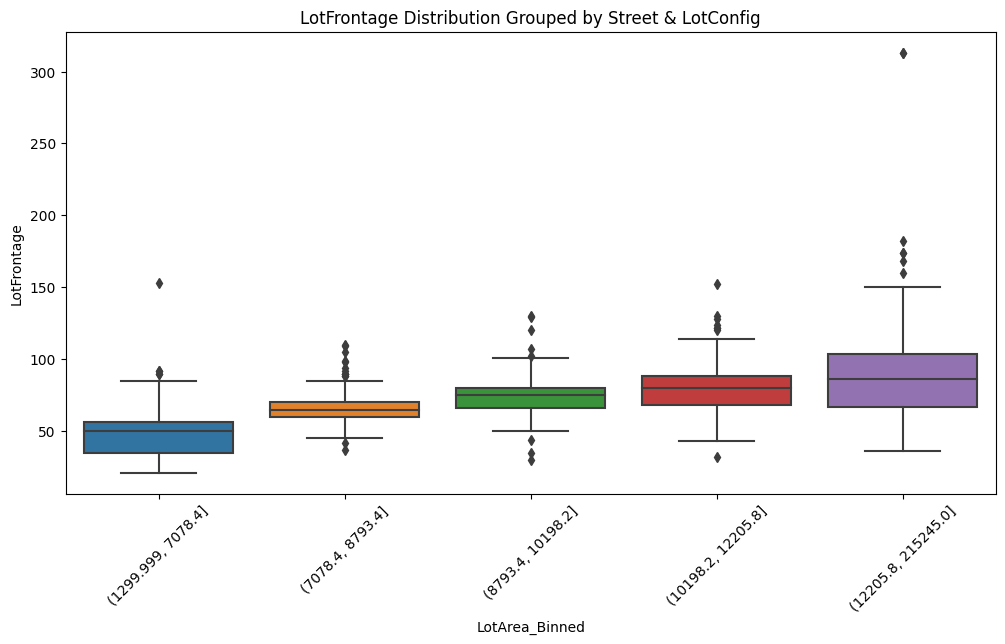

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouping key based on the selected columns
group_cols = ['Street', 'Alley', 'LotArea', 'LotConfig']

# Convert 'LotArea' to categorical bins if it has too many unique values
df_v1['LotArea_Binned'] = pd.qcut(df_v1['LotArea'], q=5, duplicates='drop')

# Boxplot of LotFrontage grouped by these categories
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_v1, 
    x='LotArea_Binned', 
    y='LotFrontage',
    dodge=True
)
plt.xticks(rotation=45)
plt.title("LotFrontage Distribution Grouped by Street & LotConfig")
plt.show()


### Although we have some outliers (due to some other effects), that's good enough for a first approach. I will folow with this grouping

In [12]:
# Bin 'LotArea' into 500 equal-width bins
df_v1['LotArea_Binned'] = pd.cut(df_v1['LotArea'], bins=500)

# Fill NaN values in 'LotFrontage' based on the mean of LotFrontage for each LotArea_Binned group
df_v1['LotFrontage'] = df_v1.groupby('LotArea_Binned')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
df_v1['LotFrontage'] = df_v1['LotFrontage'].transform(lambda x: x.fillna(x.mean()))



<ipython-input-12-80f67ec5674b>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_v1['LotFrontage'] = df_v1.groupby('LotArea_Binned')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))


### For GarageYrBuilt and MasVnrArea, I will input the null values with 0

In [13]:
df_v1[['GarageYrBlt', 'MasVnrArea']] = \
    df_v1[['GarageYrBlt', 'MasVnrArea']].apply(lambda x: x.fillna(0))

### And now, all of the columns are "complete", without any null values. Now let's check for correlation

In [14]:
from sklearn.feature_selection import VarianceThreshold

# Select only numeric columns (ensure you're applying it to float and int types)
numeric_columns = df_v1.select_dtypes(include=['float64', 'int64'])

# Initialize the VarianceThreshold with a desired threshold (e.g., 0.01)
selector = VarianceThreshold(threshold=0.05)

# Apply the selector to the numeric columns
df_v1_variance = selector.fit_transform(numeric_columns)

# Get the columns that are kept after variance thresholding
kept_columns = numeric_columns.columns[selector.get_support()]
print("Columns kept after variance thresholding:", kept_columns)

# You can now apply the selected columns to the main dataframe
#df_v1 = df_v1[kept_columns]


Columns kept after variance thresholding: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


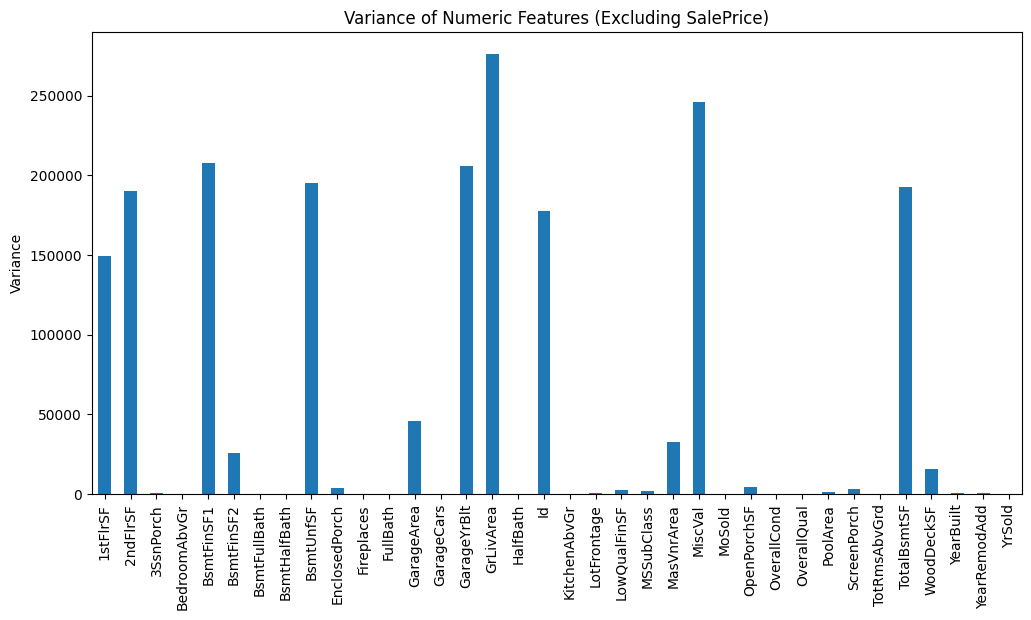

In [15]:
# Drop 'SalePrice' from the numeric columns before calculating variance
numeric_columns_no_saleprice = numeric_columns.columns.difference(['SalePrice','LotArea'])

# Check the variance of each numeric column (excluding 'SalePrice')
variance = df_v1[numeric_columns_no_saleprice].var()

# Plot the variance of the remaining numeric columns
variance.plot(kind='bar', figsize=(12, 6))
plt.title('Variance of Numeric Features (Excluding SalePrice)')
plt.ylabel('Variance')
plt.show()


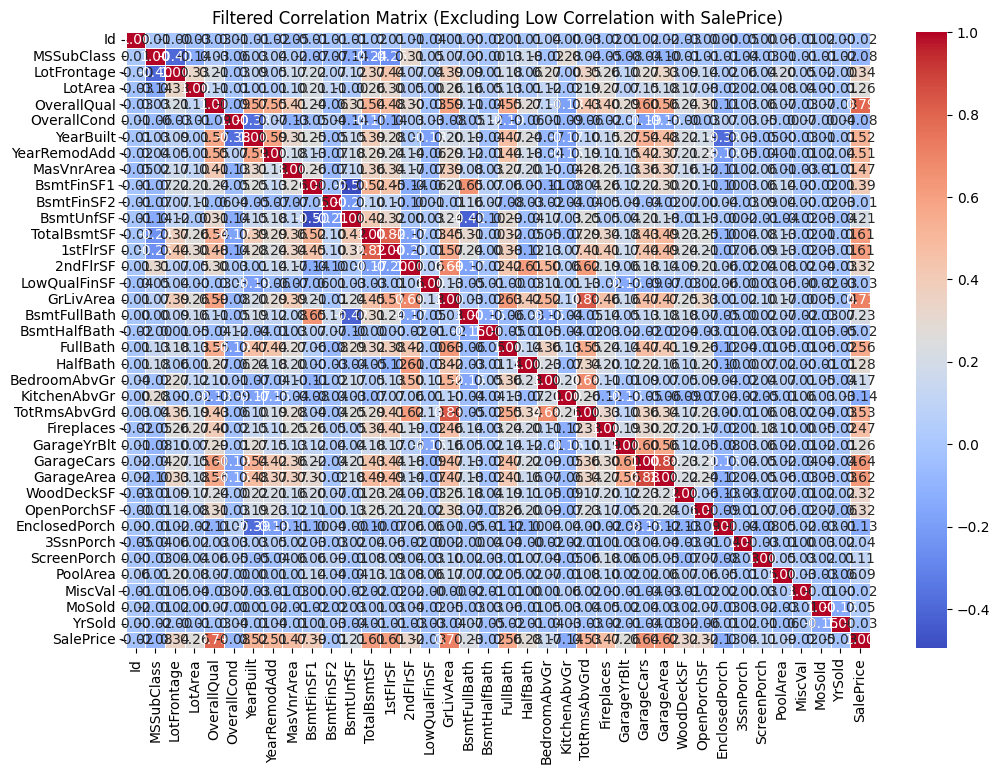

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df_v1[numeric_columns.columns].corr()

# Mask correlations with SalePrice that are between -0.005 and 0.005
# Apply the mask to only keep correlations with SalePrice that are outside the range
mask = (corr_matrix['SalePrice'] < -0.005) | (corr_matrix['SalePrice'] > 0.005)

# Filter the correlation matrix based on the mask (keeping only the relevant columns)
corr_matrix_filtered = corr_matrix.loc[mask, mask] # Keep both rows and columns where the mask is True

# Plot the filtered correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_filtered, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Filtered Correlation Matrix (Excluding Low Correlation with SalePrice)')
plt.show()


### Let's filter any columns that do not have a correlation higher than 5% (absolute value)

In [17]:
numerical_columns_good_correlation = corr_matrix_filtered[corr_matrix_filtered['SalePrice'].abs()>0.05]['SalePrice'].index

In [18]:
# Select only numeric columns (ensure you're applying it to float and int types)
CATEGORICAL_COLUMNS = df_v1.select_dtypes(include=['object']).columns

NUMERICAL_COLUMNS = numerical_columns_good_correlation.difference(['SalePrice'])

TARGET = 'SalePrice'

### Now let's create a simple model to first check the most important features (that's why we will be using a random forest at the moment), and then we will drop the least important column and run a more complex model, to hopefully achieve better results

<BarContainer object of 20 artists>

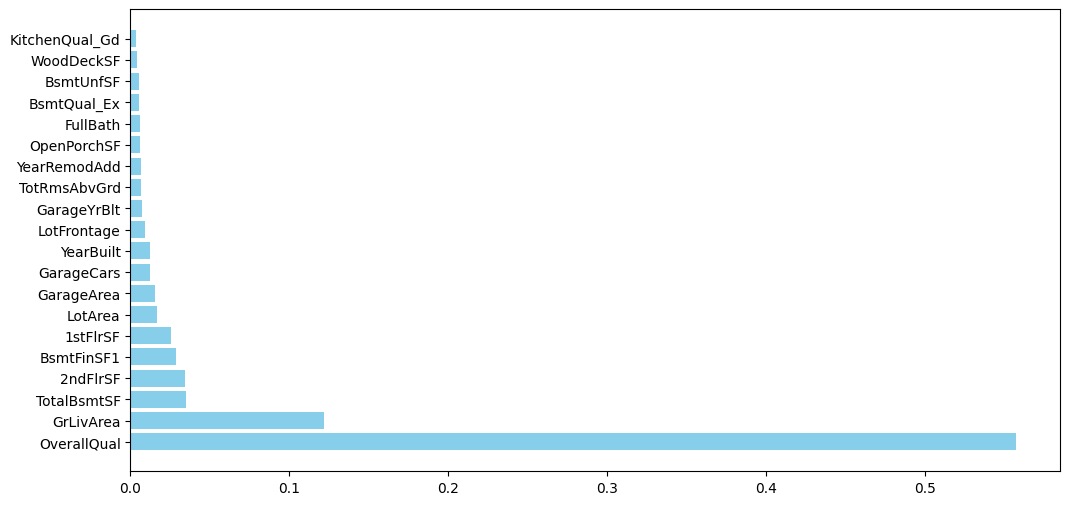

In [19]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define target and features
TARGET = 'SalePrice'

# Split data into training and test sets
X = df_v1.drop(columns=[TARGET])
y = df_v1[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define transformers for numerical and categorical features
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', num_transformer, NUMERICAL_COLUMNS),
    ('cat', cat_transformer, CATEGORICAL_COLUMNS)
])

# Define model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Get feature importance from the Random Forest model
feature_importance = model.named_steps['regressor'].feature_importances_

# Get feature names after transformation
feature_names = (list(NUMERICAL_COLUMNS) + 
                 list(model.named_steps['preprocessor'].named_transformers_['cat']
                      .named_steps['encoder'].get_feature_names_out(CATEGORICAL_COLUMNS)))

# Create a DataFrame with feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue')


In [20]:
# Get the 30 most important features
top_30_features = importance_df.sort_values(by='Importance',ascending=False).head(30)['Feature']

# Extract base feature names (before the first '_')
top_30_base_features = top_30_features.str.split('_').str[0]

# Get unique feature names
unique_important_features = top_30_base_features.unique()

# Print the result
print("Unique important base features (before one-hot encoding):")
print(unique_important_features)


Unique important base features (before one-hot encoding):
['OverallQual' 'GrLivArea' 'TotalBsmtSF' '2ndFlrSF' 'BsmtFinSF1'
 '1stFlrSF' 'LotArea' 'GarageArea' 'GarageCars' 'YearBuilt' 'LotFrontage'
 'GarageYrBlt' 'TotRmsAbvGrd' 'YearRemodAdd' 'OpenPorchSF' 'FullBath'
 'BsmtQual' 'BsmtUnfSF' 'WoodDeckSF' 'KitchenQual' 'MasVnrArea'
 'OverallCond' 'ScreenPorch' 'MSSubClass' 'CentralAir' 'GarageType'
 'Fireplaces' 'Neighborhood']


### Now that we've chosen the best parameters, let's create a more complex model

## ✅ Step 1: Divide Features into Numerical & Categorical


In [21]:
# Separate numerical and categorical features
CATEGORICAL_COLUMNS = df_v1[unique_important_features].select_dtypes(include=['object']).columns
NUMERICAL_COLUMNS = df_v1[unique_important_features].select_dtypes(include=['int64', 'float64']).columns

## ✅ Step 2: Preprocessing Pipeline

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Pipeline for numerical features
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine in a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, NUMERICAL_COLUMNS),
    ('cat', cat_transformer, CATEGORICAL_COLUMNS)
])


## ✅ Step 3: Model Comparison

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

# Define target variable
TARGET = 'SalePrice'

# Split data
X = df_v1[unique_important_features]
y = df_v1[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Dummy Regressor (Mean)": DummyRegressor(strategy="mean"),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=1000, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=1000, random_state=42)
}

# Train & evaluate models
results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    results[name] = mae
    print(f"{name} MAE: {mae:.2f}")

# Find best model
best_model = min(results, key=results.get)
print(f"Best model: {best_model} with MAE: {results[best_model]:.2f}")

Dummy Regressor (Mean) MAE: 62575.93
Linear Regression MAE: 22735.45
Random Forest MAE: 17445.49
Gradient Boosting MAE: 16692.49
Best model: Gradient Boosting with MAE: 16692.49


## ✅ Step 4: Hyperparameter Tuning (GridSearchCV)

In [24]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for tuning
param_grid = {
    'regressor__n_estimators': [100, 300, 500, 2500],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# Initialize the pipeline with the best model
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))  # Update if another model is best
])

# Perform GridSearch
grid_search = GridSearchCV(best_pipeline, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best params
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate on test data
best_preds = grid_search.best_estimator_.predict(X_test)

final_mae = mean_absolute_error(y_test, best_preds)
print(f"Final MAE after tuning: {final_mae:.2f}")


Best Hyperparameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 2500}
Final MAE after tuning: 16042.43


In [25]:
best_model_final = grid_search.best_estimator_


# Predict on df_test
test_preds = best_model_final.predict(df_test)

#Submission
submission_df = pd.DataFrame()

submission_df['Id'] = df_test['Id']
submission_df['SalePrice'] = test_preds



In [26]:
submission_df.to_csv('submission.csv', index=False)